# SMS SPAM Detection Coding Test

In [1]:
from datetime import datetime
start_datetime = datetime.now()
print("Start time of the execution: ", start_datetime)

Start time of the execution:  2021-01-21 09:33:36.426419


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [6]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam
from tqdm import tqdm

## Load the data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
data = pd.read_csv('/content/drive/MyDrive/PWC/spam.csv',encoding='latin-1')

#Got below error without encoding to latin-1, hence we need to encode the file before loading
#UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 135-136: invalid continuation byte
#https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte

## Data analysis

In [11]:
data.shape


(5572, 5)

In [12]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [13]:
data.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [14]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Looks unnamed columns doesn't give much information, hence drop these columns

In [15]:
data.drop(labels=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)

In [16]:
data.shape

(5572, 2)

In [17]:
data.columns

Index(['v1', 'v2'], dtype='object')

In [18]:
data.head(2)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [19]:
#Change the colums names
data=data.rename(columns={"v1": "labels", "v2": "text"})

In [20]:
data.columns

Index(['labels', 'text'], dtype='object')

In [21]:
data.head(2)

,labels,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


## Data Visualization

Exploratory Data Analysis (EDA)

In [22]:
ham_cnt=len(data[data['labels']=='ham'])
spam_cnt=len(data[data['labels']=='spam'])
spam_perc = spam_cnt*100/(ham_cnt+spam_cnt)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


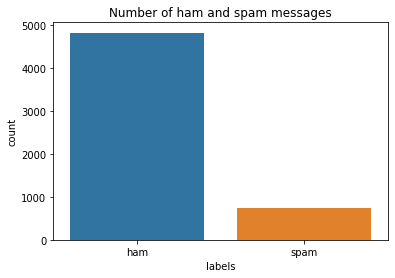


Number of ham messages 4825
Number of spam messages: 747
Percentage of spam messages -----> 13.406317300789663


In [23]:
sns.countplot(data['labels'])
plt.xlabel('labels')
plt.title('Number of ham and spam messages')
plt.show()
print()
print("Number of ham messages {}".format(ham_cnt))
print("Number of spam messages: {}".format(spam_cnt))
print("Percentage of spam messages -----> {}".format(spam_perc))

**13.4% of the SMS are labeld as SPAM**

## Data Preprocessing

In [24]:
#ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
    #data['processed_text'][i] = review

In [25]:
data['processed_text'] = corpus

In [26]:
print(len(corpus))
corpus[10]

5572


'gonna home soon want talk stuff anymore tonight k cried enough today'

In [27]:
data['text_length'] = data['processed_text'].str.len()

In [29]:
data=data.drop('text',axis=1)

In [30]:
data.columns

Index(['labels', 'processed_text', 'text_length'], dtype='object')

In [31]:
data.head()

,labels,processed_text,text_length
0,ham,go jurong point crazy available bugis n great ...,82
1,ham,ok lar joking wif u oni,23
2,spam,free entry wkly comp win fa cup final tkts st ...,101
3,ham,u dun say early hor u c already say,35
4,ham,nah think go usf life around though,35


In [32]:
y=pd.get_dummies(data['labels']) #Convert to HAM and SPAM to 0 and 1

In [33]:
y=y['ham'].values #One column is enough for labels

In [34]:
#Check the shape of data and labels
print(data.shape)
print(y.shape)

(5572, 3)
(5572,)


In [35]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)

In [36]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=3000)
X_train_bow = cv.fit_transform(X_train['processed_text']).toarray()

In [37]:
X_train_bow.shape

(4457, 3000)

In [38]:
X_test_bow=cv.transform(X_test['processed_text'])

In [39]:
X_test_bow.shape

(1115, 3000)

In [ ]:
pickle.dump(cv, open('countvectorizer.pkl','wb'))

## Pycaret for better understanding

In [40]:
pip install pycaret

     |████████████████████████████████| 256kB 8.2MB/s 
     |████████████████████████████████| 276kB 13.7MB/s 
     |████████████████████████████████| 1.6MB 14.5MB/s 
     |████████████████████████████████| 65.8MB 137kB/s 
     |████████████████████████████████| 245kB 43.0MB/s 
     |████████████████████████████████| 157.5MB 84kB/s 
     |████████████████████████████████| 174kB 40.7MB/s 
     |████████████████████████████████| 14.2MB 47.1MB/s 
     |████████████████████████████████| 1.8MB 52.1MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 6.8MB 44.0MB/s 
     |████████████████████████████████| 604kB 39.8MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 3.1MB 26.0MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 348kB 41.3MB/s 


In [ ]:
# check version
from pycaret.utils import version
version()

'2.2.3'

In [ ]:
from pycaret.classification import *
exp1 = setup(data, target='labels')

,Description,Value
0,session_id,4537
1,Target,labels
2,Target Type,Binary
3,Label Encoded,"ham: 0, spam: 1"
4,Original Data,"(5572, 3)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9077,0.8960,0.3333,1.0000,0.4957,0.4595,0.5459,8.291
et,Extra Trees Classifier,0.9077,0.8682,0.3333,1.0000,0.4957,0.4595,0.5459,20.115
ridge,Ridge Classifier,0.8949,0.0000,0.3296,0.7903,0.4622,0.4152,0.4655,2.674
dt,Decision Tree Classifier,0.8946,0.7166,0.4704,0.6981,0.5475,0.4918,0.5114,0.987
knn,K Neighbors Classifier,0.8738,0.8589,0.4833,0.5546,0.5110,0.4397,0.4442,2.360
gbc,Gradient Boosting Classifier,0.8690,0.8938,0.0667,0.9533,0.1203,0.1034,0.2192,13.542
catboost,CatBoost Classifier,0.8682,0.9004,0.0593,0.9026,0.1064,0.0915,0.1941,14.970
ada,Ada Boost Classifier,0.8623,0.8890,0.2148,0.6157,0.2385,0.1977,0.2466,3.911
xgboost,Extreme Gradient Boosting,0.8567,0.8788,0.3611,0.4764,0.4058,0.3272,0.3336,42.145
lr,Logistic Regression,0.8518,0.8955,0.0556,0.3337,0.0923,0.0533,0.0809,2.612


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=4537, verbose=0,
                       warm_start=False)

In [ ]:
rf =create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9051,0.9271,0.3148,1.0,0.4789,0.4419,0.5325
1,0.9256,0.9301,0.4630,1.0,0.6329,0.5977,0.6528
2,0.9205,0.9261,0.4259,1.0,0.5974,0.5611,0.6245
3,0.9077,0.9049,0.3333,1.0,0.5000,0.4628,0.5487
4,0.9179,0.9108,0.4074,1.0,0.5789,0.5423,0.6099
5,0.8949,0.8786,0.2407,1.0,0.3881,0.3533,0.4632
6,0.9051,0.8862,0.3148,1.0,0.4789,0.4419,0.5325
7,0.9051,0.8906,0.3148,1.0,0.4789,0.4419,0.5325
8,0.8974,0.8762,0.2593,1.0,0.4118,0.3762,0.4813
9,0.8974,0.8296,0.2593,1.0,0.4118,0.3762,0.4813


In [ ]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Models

In [42]:
mul_nb = MultinomialNB().fit(X_train_bow, y_train)

In [43]:
y_pred_nb=mul_nb.predict(X_test_bow)

In [44]:
confusion_matrix(y_pred_nb, y_test)

array([[157,   8],
       [  9, 941]])

In [45]:
accuracy_nb=accuracy_score(y_pred_nb, y_test)
accuracy_nb

0.9847533632286996

As we got 98.5% accuracy using Multinomial Naive Bayes model and keeping the time constraint in mind, not comparing with the deep learning models (CNN, LSTM, BERT etc)



## Conclusion

There are multiple options to choose the best model. I prefer to run pycaret as it gives basic idea on how the ML models are performing on the given dataset. There are mulitple options available in pycaret, I just did simple analysis. We can also run few set of models based on the understanding of the data. Usually Naive Bayes/probablistic approach works better OR gives better accuracies for the text classification problems and it is proved as per my experience and the community. Hence used MultinomianalNB for the better results. 

Also, Deep Learning (CNN, LSTMs, BERT etc) proved with better accuracies compared with the standard ML models. However, I've not tried any DL models here as per the time constraint as there are other activities to work on as per this assignment.

## Save the model

In [ ]:
# Saving model to disk
import pickle
pickle.dump(mul_nb_bow, open('model.pkl','wb'))

In [46]:
print("The time taken to run this notebook: ", datetime.now()-start_datetime)

The time taken to run this notebook:  0:16:09.590450
